In [11]:
import pandas as pd
import numpy as np

In [12]:
sku_with_cluster = pd.read_csv('sku_with_cluster.csv')
sku_with_cluster.head()

('quantity', 'mean')  ('quantity', 'sum')  ('order_ID', 'nunique')  \
0              0.016613            -0.104401                -0.104149   
1             -0.085135            -0.127381                -0.128484   
2             -0.085135            -0.127381                -0.128484   
3             -0.085135            -0.127381                -0.128484   
4             -0.041003             0.028178                 0.052921   

   ('order_hour', 'nunique') ('order_hour', 'group_mode')  \
0                   0.938484                 (20.0, 22.0]   
1                  -0.900601                  (8.0, 10.0]   
2                  -0.900601                 (13.0, 15.0]   
3                  -0.900601                   (0.0, 8.0]   
4                   1.858027                 (18.0, 20.0]   

   ('day_of_month', 'nunique')  ('day_of_month', 'group_mode')  \
0                     0.447133                              11   
1                    -0.678702                              12   
2                    -0.678702                              12   
3                    -0.678702                              19   
4                     2.448617                              14   

   ('original_unit_price', 'mean')  ('discount_rate', 'mean')  \
0                        -0.187985                  -0.670775   
1                         0.051392                   1.216695   
2                        -0.084642                   0.066594   
3                        -0.214348                  -0.719927   
4                        -0.201694                   0.268572   

   ('direct_discount_rate', 'mean')  ...  ('dc_ori', 'group_mode')  \
0                         -0.573686  ...                         2   
1                          2.359627  ...                         9   
2                          0.617621  ...                         5   
3                         -0.573686  ...                         9   
4                          0.884032  ...                         5   

   ('dc_des', 'nunique')  ('dc_des', 'group_mode')  ('promise', 'group_mode')  \
0               0.026780                         4                          -   
1              -0.585264                         9                          -   
2              -0.585264                         5                          -   
3              -0.585264                         9                          -   
4               2.092427                         4                          2   

   ('type', 'group_mode')    brand_ID  attribute1 attribute2  cluster_id  \
0                       2  9d3465eacc         4.0      100.0           0   
1                       2  42e6445fca         4.0      100.0           4   
2                       2  4f65703579         3.0      100.0          11   
3                       2  137b63c785         3.0      100.0          11   
4                       2  5a0b271e15         2.0      100.0           6   

       sku_ID  
0  000aa92b82  
1  000d4af39d  
2  000dc27e13  
3  000e84e3a7  
4  00104dbcd7  

[5 rows x 24 columns]

In [13]:
order_new = pd.read_csv('order_after_engineer.csv')
order_new.head()

sku_ID    order_ID  quantity  type promise  original_unit_price  \
0  581d5b54c1  d0cf5cc6db         1     2       -                 89.0   
1  067b673f2b  7444318d01         1     1       2                 99.9   
2  623d0a582a  f973b01694         1     1       2                 78.0   
3  fc5289b139  8c1cec8d4b         1     1       2                 61.0   
4  623d0a582a  d43a33c38a         1     1       1                 78.0   

   discount_rate  direct_discount_rate  quantity_discount_rate  \
0       0.112360               0.00000                 0.11236   
1       0.460460               0.05005                 0.41041   
2       0.250000               0.25000                 0.00000   
3       0.426230               0.00000                 0.42623   
4       0.320513               0.24359                 0.00000   

   bundle_discount_rate  gift_item  dc_ori  dc_des  day_of_month  day_of_week  \
0                   0.0          0       4      28             1            3   
1                   0.0          0      28      28             1            3   
2                   0.0          0      28      28             1            3   
3                   0.0          0       4      28             1            3   
4                   0.0          0       3      16             1            3   

   order_hour  
0          17  
1          11  
2           9  
3          21  
4          19

In [14]:
order_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549989 entries, 0 to 549988
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sku_ID                  549989 non-null  object 
 1   order_ID                549989 non-null  object 
 2   quantity                549989 non-null  int64  
 3   type                    549989 non-null  int64  
 4   promise                 549989 non-null  object 
 5   original_unit_price     549989 non-null  float64
 6   discount_rate           549989 non-null  float64
 7   direct_discount_rate    455389 non-null  float64
 8   quantity_discount_rate  461719 non-null  float64
 9   bundle_discount_rate    455389 non-null  float64
 10  gift_item               549989 non-null  int64  
 11  dc_ori                  549989 non-null  int64  
 12  dc_des                  549989 non-null  int64  
 13  day_of_month            549989 non-null  int64  
 14  day_of_week         

In [15]:
# gift_items's component discount rate are all na, fill with 0
order_new = order_new.fillna(0)

In [16]:
# aggregate order table
order_with_cluster = pd.merge(order_new, sku_with_cluster[['sku_ID', 'cluster_id','attribute1','attribute2']], how = 'left', left_on = 'sku_ID', right_on = 'sku_ID')
des_list = list(set(order_with_cluster['dc_des']))

In [20]:
def group_mode(x):
    return x.value_counts().index[0]

def agg_order_each_destination(dc_des_i):
    des_i_orders = order_with_cluster[order_with_cluster['dc_des']==dc_des_i]
    order_for_des_i = des_i_orders.groupby(['day_of_month','cluster_id']).agg(
        demand = ('quantity','sum'),
        day_of_week = ('day_of_week', lambda x: x.iloc[0]),
        order_hour_mode = ('order_hour', group_mode),
        order_hour_08 = ('order_hour', lambda x: sum((x>0) & (x<= 8))/len(x)),
        order_hour_95 = ('order_hour', lambda x: sum((x>8) & (x<= 17))/len(x)),
        att1_high = ('attribute1', lambda x: sum((x =='3.0') | (x == '4.0'))/len(x)), # percentage of high attribute1
        att1_miss = ('attribute1', lambda x: sum(x =='-')/len(x)),
        att2_high = ('attribute2', lambda x: sum((x =='70.0') | (x == '80.0')| (x == '90.0')| (x == '100.0'))/len(x)),
        att2_miss = ('attribute2', lambda x: sum(x =='-')/len(x)),
        type_1_percent = ('type', lambda x: sum(x == 1)/len(x)),
        no_promise = ('promise', lambda x: sum(x =='-')/len(x)), # no promise's percentage
        fast_promise = ('promise', lambda x: sum((x =='1') | (x == '2')| (x == '3'))/len(x)), # deliver in 3-days
        original_unit_price_mean = ('original_unit_price', 'mean'),
        discount_rate_mean = ('discount_rate','mean'),  # average discount rate
        direct_discount_rate_mean = ('direct_discount_rate', 'mean'),
        quantity_discount_rate_mean = ('quantity_discount_rate','mean'),
        bundle_discount_mean = ('bundle_discount_rate','mean'),
        gift_mean = ('gift_item','mean'),
        dc_ori_mode = ('dc_ori',group_mode),
        dc_ori_num = ('dc_ori','nunique')
    )
    return order_for_des_i

In [21]:
order_dict = dict()
for des_num in des_list:
    order_dict[des_num] = agg_order_each_destination(des_num)
    #print('destination{} dataframe has shape {}x{}'.format(des_num,len(order_dict[des_num]),len(order_dict[des_num].iloc[0])))

In [22]:
dfs_length = []
for des_num in des_list:
    dfs_length.append(len(order_dict[des_num]))

Text(0.5, 1.0, 'dataframes length distribution')

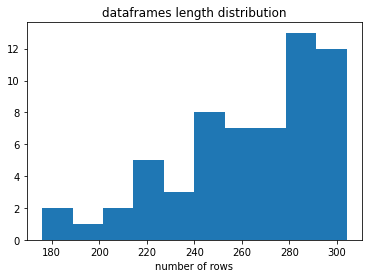

In [23]:
import matplotlib.pyplot as plt
plt.hist(dfs_length)
plt.xlabel('number of rows')
plt.title('dataframes length distribution')

In [26]:
order_dict[1].columns

Index(['demand', 'day_of_week', 'order_hour_mode', 'order_hour_08',
       'order_hour_95', 'att1_high', 'att1_miss', 'att2_high', 'att2_miss',
       'type_1_percent', 'no_promise', 'fast_promise',
       'original_unit_price_mean', 'discount_rate_mean',
       'direct_discount_rate_mean', 'quantity_discount_rate_mean',
       'bundle_discount_mean', 'gift_mean', 'dc_ori_mode', 'dc_ori_num'],
      dtype='object')